In [1]:
import sys

In [2]:
sys.path.append('/home/bh774267/.local/lib/python3.11/site-packages')

In [3]:
import requests
import pandas as pd
from io import StringIO

In [4]:
import re

In [23]:
!pip install --upgrade --user certifi

In [24]:
!pip install --user biopython

  Using cached biopython-1.86-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
Using cached biopython-1.86-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (3.2 MB)


In [25]:
!pip install --user biopython-dssp

ERROR: Could not find a version that satisfies the requirement biopython-dssp (from versions: none)
ERROR: No matching distribution found for biopython-dssp


In [26]:
import certifi
print(certifi.where())

/cvmfs/jupyter.hpc.rwth.de/clients/python311-c23/lib/python3.11/site-packages/certifi/cacert.pem


In [5]:

# SCOPe release version (e.g., 2.08 or latest)
SCOPE_VERSION = "2.08"

# URLs for SCOPe classification and description files
#base_url = f"https://scop.berkeley.edu/downloads/ver={SCOPE_VERSION}/"
cla_url = f"https://scop.berkeley.edu/downloads/parse/dir.cla.scope.{SCOPE_VERSION}-stable.txt"
des_url = f"https://scop.berkeley.edu/downloads/parse/dir.des.scope.{SCOPE_VERSION}-stable.txt"

#https://scop.berkeley.edu/downloads/parse/dir.cla.scope.2.08-stable.txt
#https://scop.berkeley.edu/downloads/parse/dir.des.scope.2.08-stable.txt
# Download classification file
print("Downloading SCOPe classification file...")
cla_text = requests.get(cla_url, verify=False).text

# Parse classification lines
cla_rows = []
for line in cla_text.splitlines():
    if line.startswith("#") or not line.strip():  # skip comments
        continue
    parts = line.strip().split()
    # Example line: d1uxya_ 1uxy A: - a.1.1.1
    if len(parts) < 5:
        # skip malformed or short lines
        continue
    domain_id = parts[0]
    pdb_id = parts[1][:4]
    chain = parts[2]
    classification = parts[3]
    
    pattern = r'^([a-z])'
    cla_rows.append((domain_id, pdb_id, chain, classification))

df_cla = pd.DataFrame(cla_rows, columns=["domain", "pdb_id", "chain", "fold_id"])
df_cla['main_class'] = df_cla['fold_id'].str.extract(pattern, expand=False)

print(f"Parsed {len(df_cla)} SCOPe domains")
print(df_cla.head())


/cvmfs/jupyter.hpc.rwth.de/clients/python311-c23/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'scop.berkeley.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Parsed 344851 SCOPe domains
    domain pdb_id chain  fold_id main_class
0  d1ux8a_   1ux8    A:  a.1.1.1          a
1  d1dlwa_   1dlw    A:  a.1.1.1          a
2  d1uvya_   1uvy    A:  a.1.1.1          a
3  d1dlya_   1dly    A:  a.1.1.1          a
4  d1uvxa_   1uvx    A:  a.1.1.1          a


In [6]:
train_labels = df_cla['main_class']
class_counts = train_labels.value_counts().sort_index()

# Convert counts to a NumPy array for easy calculation
counts = class_counts.values
print(counts)

[44351 76704 84010 76035  7353  7018  7138  2715  2866   978   316 35367]


In [7]:
df_cla_subset = df_cla.sample(n=5000, random_state=42)


#df_cla_subset.main_class.nunique()
train_labels = df_cla_subset['main_class']
#train_labels = df_cla['main_class']
class_counts = train_labels.value_counts().sort_index()

counts = class_counts.values
#df_cla_subset.pdb_id.nunique()
#df_cla_subset.count()

rare_classes_to_drop = []
for label, count in class_counts.items():
    if count < 500:
        #print(label,count)
        rare_classes_to_drop.append(label)
#print(rare_classes_to_drop)

#rare_classes_to_drop = ['k', 'j', 'i', 'h']
df_filtered = df_cla_subset[~df_cla_subset['main_class'].isin(rare_classes_to_drop)].copy()

# 1. Get the unique remaining original labels (e.g., [0, 1, 2, 3, 4, 5, 6, 11])
unique_classes = sorted(df_filtered['main_class'].unique()) 
print(unique_classes)
print("N unique classes after filtering:", df_filtered['main_class'].nunique())

# 2. Assign a new, zero-based index to each remaining original label
class_map = {old_label: new_label for new_label, old_label in enumerate(unique_classes)}

# 3. Apply the map to the DataFrame
df_filtered['mapped_class'] = df_filtered['main_class'].map(class_map)

df_filtered['mapped_class'].nunique()

#train_labels = df_filtered['main_class']
#class_counts = train_labels.value_counts().sort_index()

# Convert counts to a NumPy array for easy calculation
#counts = class_counts.values
#print(counts)

['a', 'b', 'c', 'd', 'l']
N unique classes after filtering: 5


5

In [17]:
class_value = df_cla_subset['main_class']!=5
print(class_value)

168673    True
328794    True
150848    True
24057     True
240283    True
          ... 
57456     True
63806     True
72293     True
125699    True
105497    True
Name: main_class, Length: 5000, dtype: bool


In [51]:
SCOP_TO_INT = {
    'a': 0, 'b': 1, 'c': 2, 'd': 3,
    'e': 4, 'f': 5, 'g': 6, 'h': 7,
    'i': 8,'j': 9, 'k': 10, 'l': 11
}

INT_TO_CLASS_NAME = {
    0: 'All alpha proteins',
    1: 'All beta proteins',
    2: 'Alpha/beta proteins',
    3: 'Alpha+beta proteins',
    4: 'Small proteins',
    5: 'Multi-domain proteins',
    6: 'Membrane proteins',
    7: 'Peptides/Coiled coils',
    8: 'Artificially generated peptides',
    9: 'Low resolution structures' ,
    10: 'Proteins that have not been classified',
    11: 'Others (Peptides/fragments)'
}

In [8]:
import os
import numpy as np
import pandas as pd
from Bio.PDB import PDBParser
from Bio.PDB import PDBList

pdbl = PDBList()

def ensure_dir(directory):
    """Create directory if it doesn’t exist."""
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        #print(f"[INFO] Created directory: {directory}")


def get_pdb_path(pdb_id, pdb_dir, max_retries=3):
    if max_retries < 1:
        max_retries = 3
    
    #print(f"[DEBUG] {pdb_id}: max_retries = {max_retries}")
    ensure_dir(pdb_dir)

    pdb_id = pdb_id.lower()
    
    pdb_path = os.path.join(pdb_dir, f"{pdb_id}.pdb")

    if os.path.exists(pdb_path) and os.path.getsize(pdb_path) > 1000:
        return pdb_path
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    for attempt in range(1, max_retries + 1):
        try:
            response = requests.get(url, timeout=15)
            if response.status_code == 200 and len(response.text) > 1000:
                with open(pdb_path, "w") as f:
                    f.write(response.text)
                #print(f"[INFO] Downloaded {pdb_id} (attempt {attempt})")
                return pdb_path
            elif response.status_code == 404:
                print(f"[WARN] {pdb_id} not found (HTTP 404)")
                return None
            else:
                print(f"[WARN] Attempt {attempt}: {pdb_id} failed (HTTP {response.status_code})")
        except Exception as e:
            print(f"[ERROR] {pdb_id} attempt {attempt} failed: {e}")
        
        # Wait before retrying
        time.sleep(2)

    # Only runs if all attempts failed
    print(f"[ERROR] Could not download {pdb_id} after {max_retries} attempts.")
    return None

In [9]:

def extract_ca_coordinates(pdb_path, chain_id):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    
    try:
        chain = structure[0][chain_id]
    except KeyError:
        print(f"[WARN] Chain {chain_id} not found in {os.path.basename(pdb_path)}")
        return None, None
    
    coords, res_ids = [], []
    for residue in chain:
        if "CA" in residue:
            coords.append(residue["CA"].get_coord())
            res_ids.append(residue.get_id()[1])
    
    if not coords:
        print(f"[WARN] No Cα atoms found in {os.path.basename(pdb_path)} chain {chain_id}")
        return None, None
    
    return res_ids, np.array(coords)

def parse_all_pdbs(df, pdb_dir):
    results = []
    ensure_dir(pdb_dir)
    count = 0
    
    for i, row in df.iterrows():
        pdb_id = row['pdb_id'].upper()
        chain_id = row['chain'].strip().split(':')[0]
        fold_id = row['fold_id']
        domain = row['domain']
        main_class = row['main_class']
        pdb_path = get_pdb_path(pdb_id, pdb_dir,count)
        if pdb_path is None:
            continue
        print(f"Extracting {pdb_id} chain {chain_id}")
        res_ids, coords = extract_ca_coordinates(pdb_path, chain_id)
        print(" → Residues:", len(res_ids) if res_ids else 0)
        if coords is None:
            continue
            
        results.append({
            'pdb_id': pdb_id,
            'chain': chain_id,
            'fold_id': fold_id,
            'domain': domain,
            'main_class' : main_class,
            'n_residues': len(res_ids),
            'res_ids': res_ids,
            'ca_coords': coords
        })
    
    return pd.DataFrame(results)


In [10]:
pdb_dir = "pdb_files"

parsed_df = parse_all_pdbs(df_filtered, pdb_dir)

Extracting 1GYT chain D
 → Residues: 503
Extracting 3QUC chain A
 → Residues: 225
Extracting 6B7F chain A
 → Residues: 159
Extracting 5EP8 chain B
 → Residues: 433
Extracting 1B47 chain B
 → Residues: 305
Extracting 4QZ6 chain C
 → Residues: 240
Extracting 4PJC chain G
 → Residues: 197
Extracting 2QZ0 chain A
 → Residues: 224
Extracting 4MVW chain B
 → Residues: 536
Extracting 6IJN chain A
 → Residues: 341
Extracting 2F6D chain A
 → Residues: 492
Extracting 4N99 chain B
 → Residues: 366
Extracting 6VDR chain A
 → Residues: 137
Extracting 1CBK chain A
 → Residues: 160
Extracting 1XNR chain J
 → Residues: 98
Extracting 6X0C chain A
 → Residues: 253
Extracting 3II0 chain D
 → Residues: 407
Extracting 7N7Z chain A
 → Residues: 396
Extracting 6BVA chain A
 → Residues: 86
Extracting 4O7U chain D
 → Residues: 315
Extracting 8ATC chain A
 → Residues: 310
Extracting 1ZKN chain A
 → Residues: 334
Extracting 1EZV chain Y
 → Residues: 107
Extracting 5K1V chain B
 → Residues: 849
Extracting 1Q0G ch

In [11]:
parsed_df.columns

Index(['pdb_id', 'chain', 'fold_id', 'domain', 'main_class', 'n_residues',
       'res_ids', 'ca_coords'],
      dtype='object')

In [12]:
parsed_df.head(10)

pdb_id chain    fold_id   domain main_class  n_residues  \
0   1GYT     D   c.50.1.1  d1gytd1          c         503   
1   3QUC     A    l.1.1.1  d3quca2          l         225   
2   6B7F     A   c.26.1.3  d6b7fa1          c         159   
3   5EP8     B   a.46.2.0  d5ep8b1          a         433   
4   1B47     B   d.93.1.1  d1b47b3          d         305   
5   4QZ6     C  d.153.1.0  d4qz6c1          d         240   
6   4PJC     G    b.1.1.0  d4pjcg1          b         197   
7   2QZ0     A   d.22.1.1  d2qz0a_          d         224   
8   4MVW     B   a.27.1.0  d4mvwb2          a         536   
9   6IJN     A    l.1.1.1  d6ijna2          l         341   

                                             res_ids  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5...   
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
7  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...   
8  [-4, -3, -2, -1, 0, 237, 238, 239, 240, 241, 2...   
9  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                           ca_coords  
0  [[43.051, 72.512, -36.076], [43.656, 75.149, -...  
1  [[-10.775, 17.556, -22.427], [-13.968, 19.307,...  
2  [[32.492, 124.4, 199.541], [32.398, 121.944, 1...  
3  [[-13.57, 23.96, 40.081], [-11.01, 26.79, 40.2...  
4  [[10.97, 33.014, 61.748], [13.983, 33.508, 59....  
5  [[34.223, -95.937, 33.664], [33.861, -92.274, ...  
6  [[-36.69, 17.675, 197.504], [-33.073, 16.414, ...  
7  [[-0.553, 22.985, 15.575], [0.782, 20.309, 13....  
8  [[-12.849, 13.549, -20.477], [-11.962, 15.363,...  
9  [[35.155, 11.067, 1.827], [32.14, 11.011, -0.4...

In [13]:
parsed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4621 entries, 0 to 4620
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pdb_id      4621 non-null   object
 1   chain       4621 non-null   object
 2   fold_id     4621 non-null   object
 3   domain      4621 non-null   object
 4   main_class  4621 non-null   object
 5   n_residues  4621 non-null   int64 
 6   res_ids     4621 non-null   object
 7   ca_coords   4621 non-null   object
dtypes: int64(1), object(7)
memory usage: 288.9+ KB


In [14]:
print("Label min:", parsed_df['main_class'].min())
print("Label max:", parsed_df['main_class'].max())
print("Number of unique labels:", parsed_df['main_class'].nunique())
print("Top 30 chains",parsed_df['main_class'].head(30))

Label min: a
Label max: l
Number of unique labels: 8
Top 30 chains 0     c
1     l
2     c
3     a
4     d
5     d
6     b
7     d
8     a
9     l
10    a
11    d
12    a
13    d
14    d
15    c
16    l
17    c
18    d
19    d
20    c
21    a
22    b
23    a
24    a
25    a
26    c
27    d
28    c
29    b
Name: main_class, dtype: object


In [14]:
parsed_df.describe()

n_residues
count  4621.000000
mean    274.374594
std     171.146875
min       7.000000
25%     158.000000
50%     233.000000
75%     339.000000
max    1486.000000

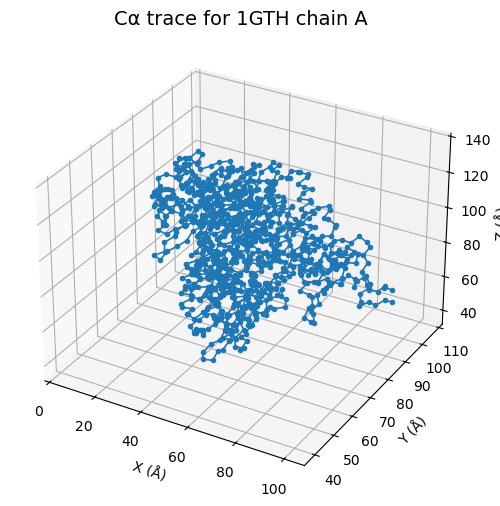

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting tools

# Pick one structure to visualize
i = 1000  # change index to view another one
coords = parsed_df.loc[i, 'ca_coords']
pdb_id = parsed_df.loc[i, 'pdb_id']
chain = parsed_df.loc[i, 'chain']

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the CA trace (connected by lines)
ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], '-o', markersize=3, linewidth=1.2)

ax.set_title(f'Cα trace for {pdb_id} chain {chain}', fontsize=14)
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
plt.show()


In [28]:
!pip install --user py3Dmol

In [16]:
import py3Dmol

pdb_id = parsed_df.loc[1000, 'pdb_id']
pdb_path = f"pdb_files/{pdb_id.lower()}.pdb"

with open(pdb_path) as f:
    pdb_data = f.read()

viewer = py3Dmol.view(width=600, height=400)
viewer.addModel(pdb_data, 'pdb')
viewer.setStyle({'cartoon': {'color': 'spectrum'}})
viewer.zoomTo()
viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [22]:
import numpy as np

def voxelize_ca_old(coords, grid_size=32, padding=5.0):
    """
    Convert Cα coordinates to a 3D voxel grid.

    coords: np.array of shape (N,3)
    grid_size: number of voxels per axis
    padding: extra space around protein (Å)
    
    Returns: 3D numpy array (grid_size, grid_size, grid_size)
    """
    coords = np.array(coords)
    
    # Translate protein to origin
    min_coords = coords.min(axis=0) - padding
    max_coords = coords.max(axis=0) + padding
    coords = coords - min_coords
    
    # Scale to grid
    scale = (grid_size - 1) / (max_coords - min_coords).max()
    coords_scaled = (coords * scale).astype(int)
    
    # Initialize empty grid
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    
    # Set voxels for Cα positions
    for x, y, z in coords_scaled:
        grid[x, y, z] = 1.0
    
    return grid

In [60]:
import numpy as np
def voxelize_ca(coords, grid_size, sigma=2.0):
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    resolution=2.0
    # Normalize coordinates to [0, grid_size-1]
    coords = np.array(coords)
    #min_coords = coords.min(axis=0)
    #max_coords = coords.max(axis=0)
    #coords_scaled = (coords - min_coords) / (max_coords - min_coords + 1e-6) * (grid_size - 1)
    coords_centered = coords - coords.mean(axis=0)
    grid_center_idx = grid_size / 2
    
    coords_mapped = (coords_centered / resolution) + grid_center_idx
    for x, y, z in coords_mapped:
        # Round to nearest integer index
        xi, yi, zi = int(round(x)), int(round(y)), int(round(z))
        
        # Spread points with a small Gaussian kernel
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                for dz in range(-1, 2):
                    x_idx = xi + dx
                    y_idx = yi + dy
                    z_idx = zi + dz
                    
                    # Boundary Check: Only fill voxels within the grid limits [0, grid_size-1]
                    if 0 <= x_idx < grid_size and 0 <= y_idx < grid_size and 0 <= z_idx < grid_size:
                        # Simple distance-based weighting (Gaussian-like)
                        weight = np.exp(-(dx**2 + dy**2 + dz**2) / (2 * sigma**2))
                        grid[x_idx, y_idx, z_idx] += weight
                        
    # 4. Normalize to [0,1]
    # Handle the case where the grid might be entirely empty (unlikely with Cα but good practice)
    if grid.max() > 0:
        grid = grid / grid.max()
        
    return grid

In [61]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# Encode fold IDs as integers
le = LabelEncoder()
parsed_df['fold_label'] = le.fit_transform(parsed_df['main_class'])

fold_counts = parsed_df['fold_label'].value_counts()
parsed_df_clean = parsed_df[parsed_df['fold_label'].isin(fold_counts[fold_counts > 1].index)]

class ProteinDataset(Dataset):
    def __init__(self, df, grid_size=48):
        self.df = df
        self.grid_size = grid_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        coords = self.df.iloc[idx]['ca_coords']
        X = voxelize_ca(coords, grid_size=self.grid_size)
        y = self.df.iloc[idx]['fold_label']
        return torch.tensor(X, dtype=torch.float32).unsqueeze(0), torch.tensor(y, dtype=torch.long)

train_df1, test_df1 = train_test_split(parsed_df_clean, test_size=0.3, stratify= parsed_df_clean['fold_label'], random_state=42, shuffle=True)

train_dataset1 = ProteinDataset(train_df1)
test_dataset1 = ProteinDataset(test_df1)

train_loader1 = DataLoader(train_dataset1, batch_size=8, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=8, shuffle=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_voxel_grid(grid):
    """
    Creates a 3D scatter plot of the non-zero voxels in the grid.
    """
    grid_size = grid.shape[0]
    
    # Get the (x, y, z) coordinates and values of all filled voxels
    filled_indices = np.argwhere(grid > 0.01) # Use a threshold to ignore near-zero values
    
    # Get the intensity (weight) of those voxels for color mapping
    intensities = grid[filled_indices[:, 0], filled_indices[:, 1], filled_indices[:, 2]]
    
    if len(filled_indices) == 0:
        print("Grid is empty (all values below threshold).")
        return

    # Create the 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot the voxel centers
    # 'c' uses the intensity for color, 's' sets the marker size
    scatter = ax.scatter(filled_indices[:, 0], 
                         filled_indices[:, 1], 
                         filled_indices[:, 2], 
                         c=intensities, 
                         cmap='viridis', 
                         s=intensities * 50, # Scale marker size by intensity
                         alpha=0.6)

    # Set axis labels and limits
    ax.set_xlabel('X Voxel Index')
    ax.set_ylabel('Y Voxel Index')
    ax.set_zlabel('Z Voxel Index')
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_zlim(0, grid_size)
    ax.set_title('Voxelized Protein Structure')

    # Add a color bar
    fig.colorbar(scatter, shrink=0.5, aspect=5, label='Voxel Density (Weight)')
    plt.show()

# --- Example Usage ---
# 1. Get Cα coordinates for a single protein
# protein_coords = ... # Assume you load this from your dataset
# 2. Run your voxelization function
# voxel_grid = voxelize_ca(protein_coords, grid_size=32)
# 3. Visualize
# visualize_voxel_grid(voxel_grid)

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# Encode fold IDs as integers
le = LabelEncoder()
parsed_df['fold_label'] = le.fit_transform(parsed_df['main_class'])


fold_counts = parsed_df['fold_label'].value_counts()
parsed_df_clean = parsed_df[parsed_df['fold_label'].isin(fold_counts[fold_counts > 1].index)]

def standardize_and_pad(distance_matrix, fixed_size, max_dist=20.0):
    """
    Standardizes the distance matrix and pads/truncates it to a fixed size.
    
    Args:
        distance_matrix (np.ndarray): The raw N x N distance matrix.
        fixed_size (int): The target output size (e.g., 128).
        max_dist (float): Maximum physical distance to consider (e.g., 20 Å).
        
    Returns:
        np.ndarray: The fixed_size x fixed_size normalized matrix.
    """
    N = distance_matrix.shape[0]
    
    # 1. Standardization (Normalization and Clipping)
    # Clip distances at max_dist and normalize to [0, 1]
    D_norm = np.clip(distance_matrix, a_min=0, a_max=max_dist) / max_dist
    
    # 2. Initialization of the final fixed-size grid
    # Use 0 (no distance, meaning no atom) as the padding value
    D_fixed = np.zeros((fixed_size, fixed_size), dtype=np.float32)

    # 3. Truncation or Padding
    if N <= fixed_size:
        # Padding (for smaller proteins): Place the N x N matrix in the top-left corner
        D_fixed[:N, :N] = D_norm
    else:
        # Truncation (for larger proteins): Only take the first fixed_size residues
        D_fixed = D_norm[:fixed_size, :fixed_size]

    return D_fixed


def calculate_distance_matrix(coords):
    #Calculates the Euclidean distance matrix between all Ca atoms.
    # Compute the squared difference of coordinates (dx^2, dy^2, dz^2)
    diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    
    # Sum the squared differences and take the square root
    distance_matrix = np.sqrt(np.sum(diff**2, axis=2))
    
    return distance_matrix
#Protein Dataset prep for distance mapping 2DCNN
class ProteinDataset(Dataset):
    def __init__(self, df, fixed_size=128): # Fixed size replaces grid_size
        self.df = df
        self.fixed_size = fixed_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        coords = self.df.iloc[idx]['ca_coords']
        
        # 1. Calculate the raw distance matrix
        D_raw = calculate_distance_matrix(coords)
        
        # 2. Resize/Pad/Normalize (This is where most logic goes)
        D_fixed = standardize_and_pad(D_raw, self.fixed_size) 
        
        y = self.df.iloc[idx]['fold_label']
        
        # Output shape for 2D CNN: (1, H, W) -> (1, fixed_size, fixed_size)
        return torch.tensor(D_fixed, dtype=torch.float32).unsqueeze(0), torch.tensor(y, dtype=torch.long)

"""
#Protein DataSet prep for Vexolize 3D CNN
class ProteinDataset(Dataset):
    def __init__(self, df, grid_size=48):
        self.df = df
        self.grid_size = grid_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        coords = self.df.iloc[idx]['ca_coords']
        X = voxelize_ca(coords, grid_size=self.grid_size)
        y = self.df.iloc[idx]['fold_label']
        return torch.tensor(X, dtype=torch.float32).unsqueeze(0), torch.tensor(y, dtype=torch.long)
"""

train_df, test_df = train_test_split(parsed_df_clean, test_size=0.3, stratify= parsed_df_clean['fold_label'], random_state=42, shuffle=True)

train_dataset = ProteinDataset(train_df)
test_dataset = ProteinDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [27]:
print("Label min:", parsed_df['fold_label'].min())
print("Label max:", parsed_df['fold_label'].max())
print("Number of unique labels:", parsed_df['fold_label'].nunique())
"""
for i in range(5):
    features, label = train_dataset[i]
    print(f"Sample {i}:")
    print("  Features shape:", features.shape)
    print("  Label:", label.item())
"""
# 1. Get the counts of each class label (0 to 11) in the training data
train_labels = train_df['fold_label']
class_counts = train_labels.value_counts().sort_index()

# Convert counts to a NumPy array for easy calculation
counts = class_counts.values
print(counts)

Label min: 0
Label max: 7
Number of unique labels: 8
[247 465 509 490  50  41  42 221]


In [28]:
class Protein3DCNN(nn.Module):
    
    def __init__(self, num_classes, dropout_rate=0.5):
        super(Protein3DCNN, self).__init__()
        
        # Layer 1: Convolve 1 channel input to 16 feature maps
        # Input: (1, 32, 32, 32)
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2) 
        # Output after pooling: (16, 16, 16, 16)
        
        # Layer 2: Convolve 16 feature maps to 32
        # Input: (16, 16, 16, 16)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        # Output after pooling: (32, 8, 8, 8)
        
        # Layer 3: Convolve 32 feature maps to 64
        # Input: (32, 8, 8, 8)
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        # Output after pooling: (64, 4, 4, 4)
        
        # Fully Connected Layer dimensions: 64 channels * 4 * 4 * 4 = 4096 features
        self.fc1_input_features = 64 * 6 * 6 * 6 
        self.fc1 = nn.Linear(self.fc1_input_features, 512)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        # Output Layer
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Convolutional Block 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # Convolutional Block 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Convolutional Block 3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the feature maps for the FC layers
        x = x.view(x.size(0), -1) # Flatten to (Batch_Size, 4096)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

num_classes = parsed_df['fold_label'].nunique()

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Protein2DCNN(nn.Module):
    def __init__(self, num_classes, input_size=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        #self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.2)

        final_dim = input_size // (2*2*2)
        
        self.fc1 = nn.Linear(64* final_dim * final_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
       # x = self.pool(F.relu(self.conv4(x)))
        #print("Feature map shape before flatten:", x.shape)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = parsed_df['fold_label'].nunique()
print(num_classes)


5


In [25]:
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

#weights = 1.0 / counts
#weights = weights * (np.sum(counts) / len(counts))

#class_weights = torch.tensor(weights, dtype=torch.float32)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#class_weights = class_weights.to(device)
model = Protein2DCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss() #weight=class_weights)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)



train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
test_f1_history = [] 

loss_bench = 0
n_epochs = 50

def cnn_test(model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            
            # Calculate and accumulate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
        avg_loss = running_loss / len(test_loader)
        accuracy = correct / len(test_loader.dataset)
        
    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, macro_precision, macro_recall, macro_f1

# --- Training Loop ---
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Calculate Training Metrics
    train_avg_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    
    # Store Training History
    train_loss_history.append(train_avg_loss)
    train_acc_history.append(train_accuracy*100)
    
    # Evaluate on Test Set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = cnn_test(model, criterion, device)

    scheduler.step(val_loss)
    
    # Store Test History
    test_loss_history.append(val_loss)
    test_acc_history.append(val_accuracy*100)
    test_f1_history.append(val_f1) # Example of tracking
    
    
    epoch_duration = end_time - start_time
    
    # Print Epoch Summary 
    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_avg_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f} | "
          f"Time: {epoch_duration:.2f}s")

Epoch 01: Train Loss: 1.5697, Train Acc: 0.2616 | Test Loss: 1.5524, Test Acc: 0.2805 | Precision: 0.1175, Recall: 0.2142, F1: 0.1109 | Time: 7.80s
Epoch 02: Train Loss: 1.5507, Train Acc: 0.2761 | Test Loss: 1.5490, Test Acc: 0.2819 | Precision: 0.1972, Recall: 0.2155, F1: 0.1166 | Time: 7.80s
Epoch 03: Train Loss: 1.5494, Train Acc: 0.2894 | Test Loss: 1.5470, Test Acc: 0.2797 | Precision: 0.1212, Recall: 0.2136, F1: 0.1100 | Time: 7.82s
Epoch 04: Train Loss: 1.5478, Train Acc: 0.2907 | Test Loss: 1.5437, Test Acc: 0.2949 | Precision: 0.1133, Recall: 0.2262, F1: 0.1298 | Time: 7.84s
Epoch 05: Train Loss: 1.5448, Train Acc: 0.2944 | Test Loss: 1.5408, Test Acc: 0.2963 | Precision: 0.1140, Recall: 0.2274, F1: 0.1316 | Time: 7.78s
Epoch 06: Train Loss: 1.5410, Train Acc: 0.2975 | Test Loss: 1.5358, Test Acc: 0.2956 | Precision: 0.2138, Recall: 0.2269, F1: 0.1322 | Time: 7.78s
Epoch 07: Train Loss: 1.5370, Train Acc: 0.2968 | Test Loss: 1.5325, Test Acc: 0.2942 | Precision: 0.1127, Recal

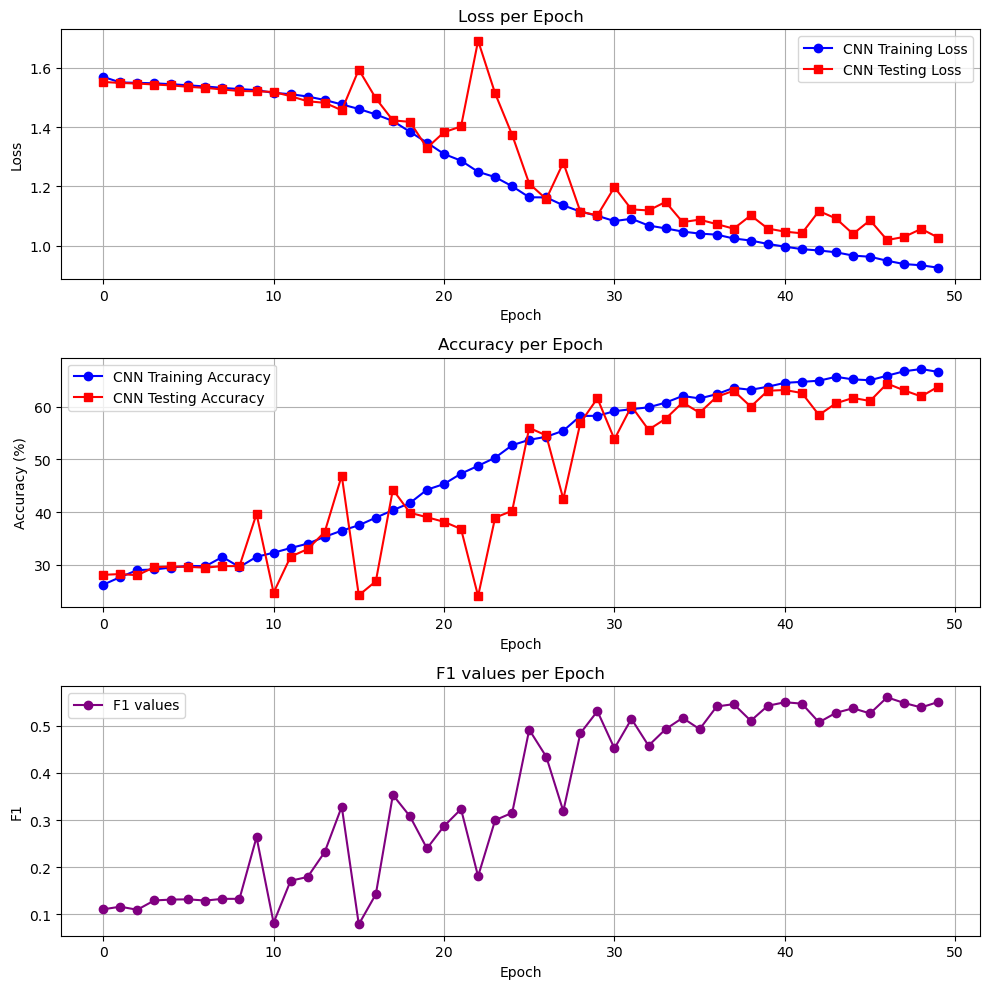

In [26]:

import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(3, 1,1)
plt.plot(train_loss_history, marker='o', label='CNN Training Loss', color='blue')
plt.plot(test_loss_history,marker='s', label='CNN Testing Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(3, 1, 2)
plt.plot(train_acc_history, marker= 'o', label='CNN Training Accuracy', color= 'blue')
plt.plot(test_acc_history,marker= 's', label= 'CNN Testing Accuracy', color= 'red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(test_f1_history, marker= 'o', label='F1 values', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid(True)
plt.legend()

"""
plt.subplot(3, 1, 4)
plt.plot(epoch_duration, marker= 'o', label='Elapsed time per Epoch', color= 'orange')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Elapsed time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time')
plt.grid(True)
plt.legend()

"""
plt.tight_layout()
#plt.savefig('protein_fold_classification_2DCNN_.png')
plt.show()

In [29]:
from ptflops import get_model_complexity_info
inputs, _ = next(iter(train_loader))
input_res = tuple(inputs.shape[1:])  # drop batch dimension

macs, params = get_model_complexity_info(
    model,
    input_res,
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True
)

Protein2DCNN(
  2.12 M, 100.000% Params, 43.12 MMac, 97.916% MACs, 
  (conv1): Conv2d(160, 0.008% Params, 2.62 MMac, 5.952% MACs, 1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4.64 k, 0.219% Params, 19.01 MMac, 43.154% MACs, 16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(18.5 k, 0.872% Params, 18.94 MMac, 43.005% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(0, 0.000% Params, 458.75 KMac, 1.042% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.2, inplace=False)
  (fc1): Linear(2.1 M, 98.871% Params, 2.1 MMac, 4.762% MACs, in_features=16384, out_features=128, bias=True)
  (fc2): Linear(645, 0.030% Params, 645.0 Mac, 0.001% MACs, in_features=128, out_features=5, bias=True)
)


In [40]:
# Save the current model state dictionary
torch.save(model.state_dict(), 'final_2d_cnn_best_epoch_30.pth')

In [41]:
model.load_state_dict(torch.load('final_2d_cnn_best_epoch_30.pth', map_location=device))
model.eval() # Set the model to evaluation mode

Protein2DCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)

In [27]:
df_filtered.columns

Index(['domain', 'pdb_id', 'chain', 'fold_id', 'main_class', 'mapped_class'], dtype='object')

In [42]:
# Select a random sample from the filtered DataFrame
random_sample = parsed_df.sample(n=1).iloc[0]

# 1. Extract the data and true label
# Assuming 'coords' is the column containing the array of C-alpha coordinates
# and 'mapped_class' is the re-indexed label (0-7)
protein_coords = random_sample['ca_coords']
true_label_index = random_sample['main_class']
protein_id = random_sample['pdb_id'] # Use a relevant ID column for tracking

# 2. Generate the Distance Map (assuming you have this function available)
# The output should be 128x128 or whatever size your model expects
distance_map = calculate_distance_matrix(protein_coords)

# 3. Add Channel and Batch Dimensions for PyTorch (1, 1, 128, 128)
# Ensure the data type is float32
input_tensor = torch.tensor(distance_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

print(f"--- Testing Protein: {protein_id} ---")
print(f"True Class Index (Mapped): {true_label_index}")

--- Testing Protein: 3ZTL ---
True Class Index (Mapped): l


In [43]:
specific_protein_row = parsed_df[parsed_df['pdb_id'] == '3ZTL']
print(specific_protein_row)

    pdb_id chain  fold_id   domain main_class  n_residues  \
901   3ZTL     J  l.1.1.1  d3ztlj2          l         183   

                                               res_ids  \
901  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                             ca_coords  fold_label  
901  [[-0.8, -11.522, 17.641], [-3.725, -13.764, 18...           7  
